In [2]:
# Handling imports

import numpy as np
np.random.seed(1337) # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import MaxPooling2D, Conv2D
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import glob
from skimage import io, transform, color, exposure
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

Using TensorFlow backend.


In [3]:
# Setting parameters for the network
batch_size = 32
nb_epoch = 50
nb_classes = 43

# input image dimensions
img_rows, img_cols = 32, 32

# number of convolutional filters to use 
conv_depth_1 = 32
conv_depth_2 = 64
conv_depth_3 = 128
hidden_size = 1024
# size of pooling area for max pooling 
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
# percentage of deletion in dropout layers
dropout_conv = 0.25
dropout_hidden = 0.5

In [4]:
# Making the images more uniform

# equalize histogram of each color channel
def equalize_hist(img):
    for k in range(3):
        img[:,:,k] = exposure.equalize_hist(img[:,:,k])
    return img

# stretch contrast of each color channel
def contrast_stretch(img):
    p2, p98 = np.percentile(img, (2, 98))
    for k in range(3):
        img[:,:,k] = exposure.rescale_intensity(img[:,:,k], in_range=(p2, p98))
    return img

def process_img(img):
    img = transform.resize(img, (img_rows, img_cols), mode='constant')
    img = contrast_stretch(img)
    return img

In [ ]:
img = io.imread('GTSRB\\Final_Training\\Images\\00003\\00000_00000.ppm')
img = transform.resize(img, (img_rows, img_cols), mode='constant')
#img = equalize_hist(img)
img = contrast_stretch(img)

plt.imshow(img)

In [5]:
# Load training images and labels

#def get_class(img_path):
#    return int(img_path.split('/')[-2])
def get_class(img_path):
    return int(img_path.split('\\')[-2])

# Path to training data
#train_dir = 'GTSRB/Final_Training/Images/'
#train_images_paths = glob.glob(train_dir + '*/*.ppm', recursive=True)
train_dir = 'GTSRB\\Final_Training\\Images\\'
train_images_paths = glob.glob(train_dir + '*\\*.ppm', recursive=True)

np.random.shuffle(train_images_paths)
train_images = []
train_labels = []

for filename in train_images_paths:
    try:
        img = process_img(io.imread(filename))
        train_images.append(img)
        label = get_class(filename)
        train_labels.append(label)
    except (IOError, OSError):
        print('missed', filename)
        pass
    
X_train = np.array(train_images, dtype='float32')
Y_train = np.eye(nb_classes, dtype='uint8')[train_labels] 

class:  5


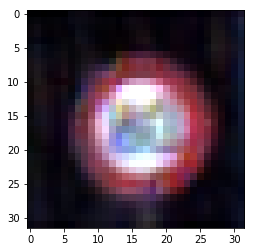

In [6]:
i = 0

plt.imshow(X_train[i])
print('class: ', np.where(Y_train[i]==1)[0][0])

In [7]:
# Load test images and labels

# Path to testing data
#test_dir = 'GTSRB/Final_Test/Images/'
#test_images_paths = glob.glob(test_dir + '*.ppm', recursive=True)
test_dir = 'GTSRB\\Final_Test\\Images\\'
test_images_paths = glob.glob(test_dir + '*.ppm', recursive=True)

test_images = []
test_csv = pd.read_csv('GT-final_test.csv',sep=';')
test_labels = list(test_csv['ClassId'])

for filename in test_images_paths:
    try:
        img = process_img(io.imread(filename))
        test_images.append(img)
    except (IOError, OSError):
        print('missed', filename)
        pass
    
X_test = np.array(test_images, dtype='float32')
Y_test = np.eye(nb_classes, dtype='uint8')[test_labels] 

class:  16


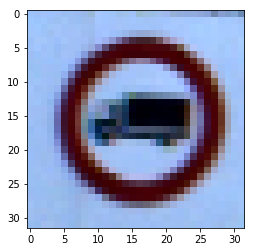

In [8]:
i = 0
plt.imshow(X_test[i])
print('class: ', np.where(Y_test[i]==1)[0][0])

In [9]:
# Processing images for theano or tensorflow backend
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols) 
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols) 
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3) 
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3) 
    input_shape = (img_rows, img_cols, 3)
    
# Converting the input from bytes to floats
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 

# Normalising the input
X_train /= np.max(X_train)
X_test /= np.max(X_test)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(len(Y_train), 'train labels')
print(X_test.shape[0], 'test samples')
print(len(Y_test), 'test labels')

# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes) #breaks stuff
#Y_test = np_utils.to_categorical(y_test, nb_classes) #breaks stuff

X_train shape: (39209, 32, 32, 3)
39209 train samples
39209 train labels
12630 test samples
12630 test labels


In [10]:
# Data Generation
datagen = ImageDataGenerator(
              featurewise_center=False,
              featurewise_std_normalization=False,
              rotation_range=10,
              width_shift_range=0.1,
              height_shift_range=0.1,
              shear_range=0.3,
              horizontal_flip=False) 

datagen.fit(X_train)

In [12]:
# Defining the network

model = Sequential()

model.add(Conv2D(conv_depth_1, (kernel_size[0], kernel_size[1]),
                 padding='same', input_shape=input_shape))
model.add(PReLU())
model.add(Conv2D(conv_depth_1, (kernel_size[0], kernel_size[1])))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(conv_depth_2, (kernel_size[0], kernel_size[1]), 
                 padding='same', kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Conv2D(conv_depth_2, (kernel_size[0], kernel_size[1]), 
                 kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(conv_depth_3, (kernel_size[0], kernel_size[1]), 
                 padding='same', kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Conv2D(conv_depth_3, (kernel_size[0], kernel_size[1]), 
                 kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(hidden_size, kernel_initializer='glorot_uniform'))
model.add(PReLU())
model.add(Dropout(dropout_hidden))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [13]:
model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [14]:
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
#          verbose=1, validation_data=(X_test, Y_test))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train)/batch_size,
                              epochs=nb_epoch,
                              validation_data=(X_test, Y_test),
                              callbacks=[reduce_lr, ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/50
1226/1225 [==============================] - 25s - loss: 2.1294 - acc: 0.3680 - val_loss: 0.5331 - val_acc: 0.8264
Epoch 2/50
1226/1225 [==============================] - 23s - loss: 0.5388 - acc: 0.8271 - val_loss: 0.2254 - val_acc: 0.9390
Epoch 3/50
1226/1225 [==============================] - 23s - loss: 0.2709 - acc: 0.9159 - val_loss: 0.1754 - val_acc: 0.9599
Epoch 4/50
1226/1225 [==============================] - 23s - loss: 0.1854 - acc: 0.9434 - val_loss: 0.1420 - val_acc: 0.9647
Epoch 5/50
1226/1225 [==============================] - 23s - loss: 0.1456 - acc: 0.9562 - val_loss: 0.1380 - val_acc: 0.9684
Epoch 6/50
1226/1225 [==============================] - 23s - loss: 0.1271 - acc: 0.9619 - val_loss: 0.1064 - val_acc: 0.9748
Epoch 7/50
1226/1225 [==============================] - 24s - loss: 0.1048 - acc: 0.9683 - val_loss: 0.1380 - val_acc: 0.9708
Epoch 8/50
1226/1225 [==============================] - 23s - loss: 0.1052 - acc: 0.9691 - val_loss: 0.0992 - val_acc:

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0835945035671
Test accuracy: 0.985114806065


dict_keys(['val_acc', 'lr', 'loss', 'val_loss', 'acc'])


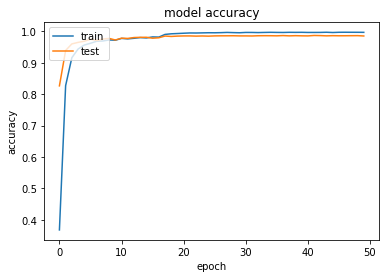

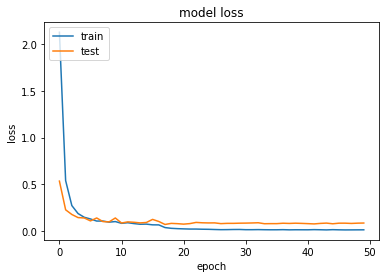

In [16]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
max(history.history['val_acc'])

0.9866983407608404

In [18]:
min(history.history['val_loss'])

0.068295487053241302